In [64]:
import ase
import time
import sys
import torch
from torch.nn import MSELoss
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from skorch.callbacks import Checkpoint, EpochScoring
from skorch.callbacks.lr_scheduler import LRScheduler
from amp.descriptor.gaussian import Gaussian
from amptorch.gaussian import SNN_Gaussian
from amptorch.model import FullNN, CustomLoss
from amptorch.data_preprocess import AtomsDataset, factorize_data, collate_amp, TestDataset
from md_work.md_utils import md_run, calculate_energies, calculate_forces, time_plots, kde_plots, calculate_rmse
from amptorch.skorch_model import AMP
from amptorch.skorch_model.utils import target_extractor, energy_score, forces_score
from amptorch.exp_repulsive import lj_optim
from amptorch.lj_12_6 import lj_optim as lj_optim_12_6
from amptorch.morse import lj_optim as lj_morse
from torch.utils.data import DataLoader
from torch.nn import init, ReLU
from skorch.utils import to_numpy
import numpy as np
from ase import Atoms, units
from ase.calculators.emt import EMT
import seaborn as sns
import skorch.callbacks.base

%matplotlib inline

In [65]:
# Define Training data
distances = []
energies = []
forces = []
distances = np.linspace(0.5, 12, 100)
images = []

label = "bond_example"
for displacement in distances:
    atoms = Atoms("CuCu", [(0, 0, 0), (0, 0, displacement)])
#     atoms.set_cell([10, 10, 10])
#     atoms.wrap(pbc=True)
    atoms.set_calculator(EMT())
    energy = atoms.get_potential_energy(apply_constraint=False)
    force = atoms.get_forces(apply_constraint=False)
    energies.append(energy)
    forces.append(force)
    images.append(atoms)

energies = np.array(energies)
forces = np.concatenate(np.array(forces))

training_images = [images[i] for i in training_idx]
training_energies = energies[training_idx]
training_distances = distances[training_idx]

In [66]:
def morse_parameters(images):
    D = energies[-1] - np.min(energies)
    print(D)
    re = distances[np.argwhere(energies == np.min(energies))].squeeze()
    print(re)
    sig = distances[np.argwhere(energies-energies[-1]<= 1e-2)].squeeze()[0]
    print(sig)
    
morse_parameters(images)

3.822986810108725
2.1262626262626263
1.7777777777777777


No handles with labels found to put in legend.


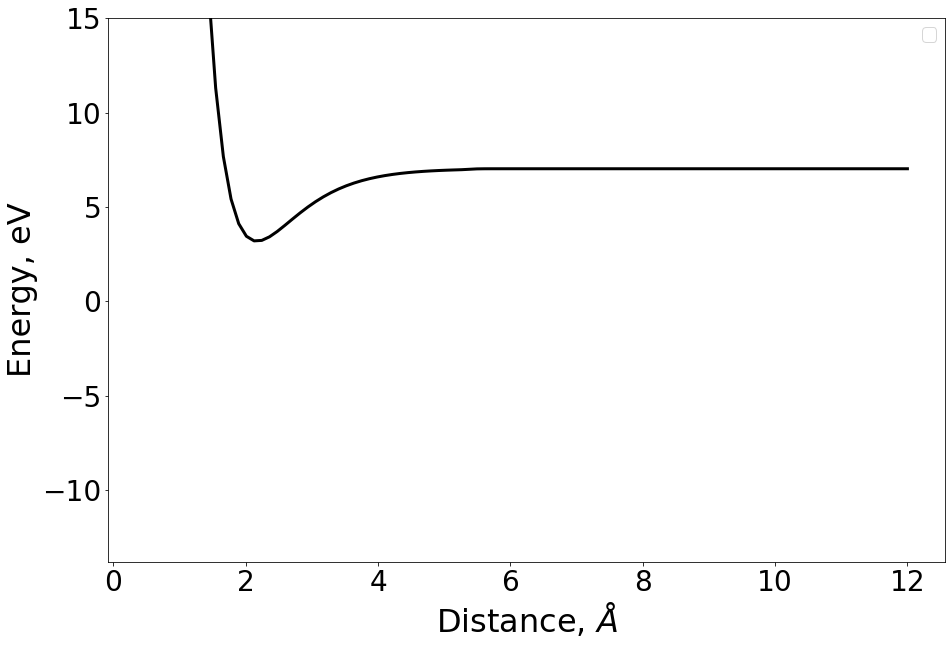

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(15,10))
ax1.set_xlabel(r"Distance, $\AA$", fontsize=32)
ax1.set_ylabel("Energy, eV", color="k", fontsize=32)
ax1.plot(distances, energies, color="k", linewidth=3)
ax1.set_ylim(top=15)
ax1.tick_params(axis="both", labelsize=28)
plt.legend(fontsize=18)

In [ ]:
def parity_plots(x, y, xlabel, ylabel, title, num_atoms, dtype="energy"):
    if dtype == "energy":
        rmse = calculate_rmse(x, y, num_atoms, dtype=dtype)
        text = f"RMSE: {rmse:.6f}eV/atom"
        lims = [0, 10]
    else:
        rmse = calculate_rmse(x, y, num_atoms, dtype=dtype)
        x = np.concatenate(np.array(x))
        y = np.concatenate(np.array(y))
        text = f"RMSE: {rmse:.6f}eV/A"
        lims = [-5, 5]
    grid = sns.jointplot(y, x)
    ax = grid.ax_joint
    _ = ax.set_xlim(lims)
    _ = ax.set_ylim(lims)
    _ = ax.plot(lims, lims, '--')
    _ = ax.set_ylabel(xlabel)
    _ = ax.set_xlabel(ylabel)
    _ = ax.text(x=lims[1], y=lims[0], s=title,
                horizontalalignment='right',
                verticalalignment='bottom',
                fontsize=14)
    _ = ax.text(x=lims[0], y=lims[1], s=text,
                horizontalalignment='left',
                verticalalignment='top',
                fontsize=14)

In [ ]:
# define symmetry functions to be used
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
Gs["G2_rs_s"] = [0] * 4
Gs["G4_etas"] = [0.005]
Gs["G4_zetas"] = [1.0, 4.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 5.876798323827276 #EMT asap_cutoff: False

In [ ]:
# Define Training data
distances = []
energies = []
forces = []
distances = np.linspace(1, 7, 100)
images = []

label = "bond_example"
for displacement in distances:
    atoms = Atoms("CuCu", [(0, 0, 0), (0, 0, displacement)])
    atoms.set_cell([10, 10, 10])
    atoms.wrap(pbc=True)
    atoms.set_calculator(EMT())
    energy = atoms.get_potential_energy(apply_constraint=False)
    force = atoms.get_forces(apply_constraint=False)
    energies.append(energy)
    forces.append(force)
    images.append(atoms)

energies = np.array(energies)
forces = np.concatenate(np.array(forces))

training_idx = np.array([6, 7, 8, 9, 10, 12, 14, 16,])
# training_idx = np.array([0, 99])
training_images = [images[i] for i in training_idx]
training_energies = energies[training_idx]
training_distances = distances[training_idx]

In [ ]:
def train(training_images, forcesonly=False, fit=False, p0=None, lj=None, method='Nelder-Mead', combo=None):
    lj_data = None
    scaling = None
    if lj is not None:
        params_dict = {"Cu": [], "C": []}
        cutoff = Gs["cutoff"]
        if lj == 'rep':
            lj_model = lj_optim(images, p0, params_dict, cutoff, label, forcesonly=forcesonly)
            lj_model = lj_optim(training_images, p0, params_dict, cutoff, "test", forcesonly=forcesonly)
        elif lj == '12_6':
            lj_model = lj_optim_12_6(images, p0, params_dict, cutoff, label, forcesonly=forcesonly)
            lj_model = lj_optim_12_6(training_images, p0, params_dict, cutoff, "test", forcesonly=forcesonly)
        elif lj == 'morse':
            lj_model = lj_morse(images, p0, params_dict, cutoff, label, combo=combo)
            lj_model = lj_morse(training_images, p0, params_dict, cutoff, "test", combo=combo)
        
        if fit:
            fitted_params = lj_model.fit(method=method)
        else:
            fitted_params = p0

        lj_energies, lj_forces, num_atoms = lj_model.lj_pred(training_images, fitted_params, params_dict)
        lj_data = [lj_energies, lj_forces, num_atoms, fitted_params, params_dict, lj_model]

        lj_energy_pred, lj_force_pred, _ = lj_model.lj_pred(images, fitted_params, params_dict)
        scaling = "rel"

    forcetraining = True
    training_data = AtomsDataset(training_images, SNN_Gaussian, Gs, forcetraining=forcetraining,
            label=label, cores=4, lj_data=lj_data, scaling=scaling)
    unique_atoms = training_data.elements
    fp_length = training_data.fp_length
    device = "cpu"

    net = NeuralNetRegressor(
        module=FullNN(unique_atoms, [fp_length, 3, 20], device, forcetraining=forcetraining),
        criterion=CustomLoss,
        criterion__force_coefficient=0.04,
        optimizer=torch.optim.LBFGS,
        optimizer__line_search_fn="strong_wolfe",
        lr=1e-1,
        batch_size=len(training_data),
        max_epochs=300,
        iterator_train__collate_fn=collate_amp,
        iterator_train__shuffle=False,
        iterator_valid__collate_fn=collate_amp,
        device=device,
        train_split= 0,
        callbacks=[
            EpochScoring(
                forces_score,
                on_train=True,
                use_caching=True,
                target_extractor=target_extractor,
            ),
            EpochScoring(
                energy_score,
                on_train=True,
                use_caching=True,
                target_extractor=target_extractor,
            ),
        ],
    )

    calc = AMP(training_data, net, label)
    calc.train()

    ml_delta_e_pred = [calc.get_potential_energy(image) for image in images]
    ml_delta_f_pred = [calc.get_forces(image) for image in images]
    
    if lj is None:
        return ml_delta_e_pred, ml_delta_f_pred
    else:
        return ml_delta_e_pred, ml_delta_f_pred, lj_energy_pred, lj_force_pred, fitted_params

In [ ]:
# ML Only
ml_pred, ml_forces = train(training_images)

In [ ]:
method = 'TNC'
forcesonly = False
fit = False

In [ ]:
# Repulsive-exp()
p0 = [  2.168,
        3.8386,
        0.972,
        6.379,
        12
    ]

mllj_rep_pred, mllj_rep_forces, lj_test_rep, lj_test_rep_force, rep_p0 =  train(
    training_images, forcesonly=forcesonly, fit=fit, p0=p0, lj='rep', method=method
)

print(rep_p0)

In [ ]:
# LJ 12-6
p0 = [  1.696,
        3.8386,
        0.477,
        6.379,
    ]

mllj_12_6_pred, mllj_12_6_forces, lj_test_12_6, lj_test_12_6_force, lj_12_6_p0 =  train(
    training_images, forcesonly=forcesonly, fit=fit, p0=p0, lj='12_6', method=method
)

print(lj_12_6_p0)

In [ ]:
# Morse
p0 = [  2.168,
        3.8386,
        1.696,
        0.972,
        6.379,
        0.477,
    ]

mllj_morse_pred, mllj_morse_forces, lj_test_morse, lj_test_morse_force, lj_morse_p0 =  train(
    training_images, p0=p0, lj='morse', combo='yang', 
)

print(lj_morse_p0)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(15,10))
ax1.set_xlabel(r"Distance, $\AA$", fontsize=32)
ax1.set_ylabel("Energy, eV", color="k", fontsize=32)
ax1.plot(distances, energies, color="k", linewidth=3)
ax1.plot(training_distances, training_energies, "ro", label="train data", markersize=8)
# ax1.plot(distances, ml_pred, "m", label="ML", linewidth=3)
# ax1.plot(distances, mllj_rep_pred, "--g", label="ML-LJ repulsive", linewidth=3)
# ax1.plot(distances, mllj_12_6_pred, "--y", label="ML-LJ 12-6", linewidth=3)
ax1.plot(distances, mllj_morse_pred, "--r", label="ML-LJ morse", linewidth=3)
# ax1.plot(distances, lj_test_rep, "-g", label="exp-repulsive", linewidth=3)
# ax1.plot(distances, lj_test_12_6, "-y", label="LJ 12-6", linewidth=3)
ax1.plot(distances, lj_test_morse, "-r", label="Morse", linewidth=3)
ax1.set_ylim(top=15)
ax1.set_ylim(bottom=-15)
ax1.tick_params(axis="both", labelsize=28)
plt.legend(fontsize=18)